In [17]:
from torch.utils.data.dataset import Dataset
from sklearn.preprocessing import LabelBinarizer
from pathlib import Path
import json
from PIL import Image
import os
from torch import from_numpy
import numpy as np
import random
import math
from enum import IntEnum
from matplotlib import pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.functional import binary_cross_entropy, relu, max_pool2d, softmax
from torchvision.transforms.functional import resize, to_tensor
from torch import max as torch_max
from torch import eq as torch_eq
from torch import save as torch_save

In [18]:
class LabelIndex(IntEnum):
    LEFT = 0
    RIGHT = 1
    NEUTRAL = 2


names = ["LEFT", "RIGHT", "NEUTRAL"]
values = [-1.0, 1.0, 0]


class Label(object):

    @staticmethod
    def steering_value_to_label_index(val):
        if val < 0:
            return LabelIndex.LEFT
        elif val > 0:
            return LabelIndex.RIGHT
        elif val == 0:
            return LabelIndex.NEUTRAL

    @staticmethod
    def label_index_to_name(label_index):
        return names[label_index]

    @staticmethod
    def label_index_to_steering_value(label_index):
        return values[label_index]

In [19]:
class TrainingDataset(Dataset):

    def __init__(self, data_dir):

        # Construct one-hot label binarizer
        lb = LabelBinarizer()
        lb.fit([0, 1, 2])

        # Initialize data lists
        self.label_list = []
        self.images = []
        self.image_filepaths = []

        # Construct data lists
        data_root = Path(data_dir)
        all_json_paths = list(data_root.glob('data_*.json'))
        all_json_paths = [str(path) for path in all_json_paths]

        for json_path in all_json_paths:
            with open(json_path) as json_file:
                print(json_path)

                # The dataset includes multiple records
                json_data_set = json.load(json_file)

                for json_data_record in json_data_set["data"]:

                    # Process image and append to list
                    image_filepath = os.path.join(data_dir, json_data_record["camera"]["filename"])
                    
                    try:
                        img = Image.open(image_filepath)
                    except Exception as e:
                        print(f"Could not load image: {str(e)}")
                        continue
                        
                    img = resize(img, (64, 64))
                    img_arr = np.array(img)
                    img_arr = self.normalize(img_arr)
                    img_tensor = to_tensor(img_arr).float()
                    self.images.append(img_tensor)
                    self.image_filepaths.append(image_filepath)

                    steering_value = json_data_record["vehicle_ctl"]["steering"]
                    label_val = Label.steering_value_to_label_index(steering_value)
                    self.label_list.append(label_val)

        self.labels = lb.transform(self.label_list).astype(np.float64)
        
    def normalize(self, arr, old_min=0, old_max=255, new_min=0, new_max=1):

        # Cast to float
        arr = arr.astype('float')

        for i in range(0, arr[0][0].size):

            arr[...,i] -= old_min
            arr[...,i] *= ((new_max - new_min) / (old_max - old_min))
            arr[...,i] += new_min

        return arr


    def __getitem__(self, index):

        img = self.images[index]
        label = from_numpy(self.labels[index]).float()

        return img, label

    def __len__(self):

        return len(self.images)

    def random_image_filepath(self):
        ind = random.randint(0, len(self.image_filepaths))
        return self.image_filepaths[ind]

In [20]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=3)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.fc1 = nn.Linear(2352, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):

        x = max_pool2d(relu(self.conv1(x)), 2)
        x = max_pool2d(relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return softmax(x, dim=1)

    def num_flat_features(self, x):

        size = x.size()[1:]
        num_flat_features = 1
        for s in size:
            num_flat_features *= s

        return num_flat_features

In [21]:
def show_image_tensor(dataset, index):
    plt.imshow(rotor_dataset[index][0].permute(1, 2, 0), cmap='gray')
    plt.show()


def show_image(images, index, result_value, label_value=None):
    plt.imshow(images[index].permute(1, 2, 0))
    result_name = Label.label_index_to_name(result_value)
    if label_value is not None:
        label_name = Label.label_index_to_name(label_value)
    else:
        label_name = "UNK"
    plt.title("Prediction: {}\nCorrect Label: {}".format(result_name, label_name))
    plt.show()

In [22]:
def train(epoch, optimizer_):
    loss_list = []

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer_.zero_grad()
        output = model(data)
        loss = binary_cross_entropy(output, target)

        loss_list.append(loss.item())

        loss.backward()
        optimizer_.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

    model.eval()
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(validation_loader):
        data, target = Variable(data), Variable(target)
        _, target_inds = torch_max(target, dim=1)

        output = model(data)
        _, output_inds = torch_max(output, dim=1)

        num_correct = torch_eq(target_inds, output_inds).sum().item()
        total_correct += num_correct
        total += len(target_inds)

    accuracy = total_correct / total * 100
    print("Model Accuracy: {:.2f}%".format(accuracy))

    return loss_list, accuracy

/Users/Robbie/rotor/rtrcmd/data/data_06122020_084231.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144439.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144655.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144615.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144753.json
/Users/Robbie/rotor/rtrcmd/data/data_18122020_131124.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144856.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144508.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144532.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144729.json
/Users/Robbie/rotor/rtrcmd/data/data_18122020_131037.json
/Users/Robbie/rotor/rtrcmd/data/data_18122020_131246.json
/Users/Robbie/rotor/rtrcmd/data/data_18122020_130953.json
/Users/Robbie/rotor/rtrcmd/data/data_10122020_144554.json
/Users/Robbie/rotor/rtrcmd/data/data_06122020_083942.json
Could not load image: cannot identify image file '/Users/Robbie/rotor/rtrcmd/data/06122020_083942_133.jpeg'
/Users/Robbie/rotor/rt

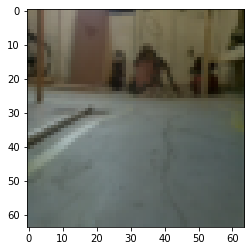

In [23]:
data_dir = "/Users/Robbie/rotor/rtrcmd/data"

# Create the dataset and show a sample image
rotor_dataset = TrainingDataset(data_dir)
show_image_tensor(rotor_dataset, 80)

In [24]:
# Split the data into training and validation data
data_size = len(rotor_dataset)
validation_split = .1
split_ind = math.floor((1 - validation_split) * data_size)
data_indices = list(range(data_size))
train_ind, validation_ind = data_indices[0:split_ind], data_indices[split_ind:]

In [25]:
# Create random samplers for the training and validation data
train_sampler = SubsetRandomSampler(train_ind)
validation_sampler = SubsetRandomSampler(validation_ind)

In [26]:
# Create data loaders for training and validation data
batch_size = 10
train_loader = DataLoader(rotor_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(rotor_dataset, batch_size=batch_size, sampler=validation_sampler)

In [27]:
# Reinitialize model
model = SimpleNet()
learning_rate = .05
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# Train
loss_list = []
accuracy_list = []
for epoch in range(0, 10):
    loss, accuracy = train(epoch, optimizer)
    loss_list.extend(loss)
    accuracy_list.append(accuracy)

Train Epoch: 0 [0/2637 (0%)]	Loss: 0.531989
Train Epoch: 0 [100/2637 (4%)]	Loss: 0.692468
Train Epoch: 0 [200/2637 (8%)]	Loss: 0.602605
Train Epoch: 0 [300/2637 (13%)]	Loss: 0.667154
Train Epoch: 0 [400/2637 (17%)]	Loss: 0.607163
Train Epoch: 0 [500/2637 (21%)]	Loss: 0.551808
Train Epoch: 0 [600/2637 (25%)]	Loss: 0.598003
Train Epoch: 0 [700/2637 (29%)]	Loss: 0.473929
Train Epoch: 0 [800/2637 (34%)]	Loss: 0.692449
Train Epoch: 0 [900/2637 (38%)]	Loss: 0.596355
Train Epoch: 0 [1000/2637 (42%)]	Loss: 0.535973
Train Epoch: 0 [1100/2637 (46%)]	Loss: 0.701957
Train Epoch: 0 [1200/2637 (50%)]	Loss: 0.519355
Train Epoch: 0 [1300/2637 (55%)]	Loss: 0.551475
Train Epoch: 0 [1400/2637 (59%)]	Loss: 0.530495
Train Epoch: 0 [1500/2637 (63%)]	Loss: 0.606344
Train Epoch: 0 [1600/2637 (67%)]	Loss: 0.622530
Train Epoch: 0 [1700/2637 (71%)]	Loss: 0.557394
Train Epoch: 0 [1800/2637 (76%)]	Loss: 0.533183
Train Epoch: 0 [1900/2637 (80%)]	Loss: 0.558028
Train Epoch: 0 [2000/2637 (84%)]	Loss: 0.577557
Train E

Train Epoch: 7 [200/2637 (8%)]	Loss: 0.543312
Train Epoch: 7 [300/2637 (13%)]	Loss: 0.309972
Train Epoch: 7 [400/2637 (17%)]	Loss: 0.218984
Train Epoch: 7 [500/2637 (21%)]	Loss: 0.273592
Train Epoch: 7 [600/2637 (25%)]	Loss: 0.347385
Train Epoch: 7 [700/2637 (29%)]	Loss: 0.235550
Train Epoch: 7 [800/2637 (34%)]	Loss: 0.659013
Train Epoch: 7 [900/2637 (38%)]	Loss: 0.476540
Train Epoch: 7 [1000/2637 (42%)]	Loss: 0.918631
Train Epoch: 7 [1100/2637 (46%)]	Loss: 0.170914
Train Epoch: 7 [1200/2637 (50%)]	Loss: 0.421440
Train Epoch: 7 [1300/2637 (55%)]	Loss: 0.170482
Train Epoch: 7 [1400/2637 (59%)]	Loss: 0.277485
Train Epoch: 7 [1500/2637 (63%)]	Loss: 0.436368
Train Epoch: 7 [1600/2637 (67%)]	Loss: 0.470547
Train Epoch: 7 [1700/2637 (71%)]	Loss: 0.349004
Train Epoch: 7 [1800/2637 (76%)]	Loss: 0.296229
Train Epoch: 7 [1900/2637 (80%)]	Loss: 0.501670
Train Epoch: 7 [2000/2637 (84%)]	Loss: 0.431364
Train Epoch: 7 [2100/2637 (88%)]	Loss: 0.396473
Train Epoch: 7 [2200/2637 (92%)]	Loss: 0.209716
T

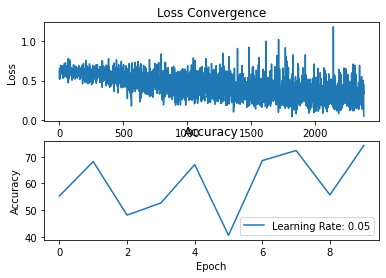

In [30]:
# Plot the loss and accuracy
fig, axs = plt.subplots(2)
legend = []
axs[0].plot(list(range(len(loss_list))), loss_list)
axs[0].set_title("Loss Convergence")
axs[0].set(xlabel='Batch', ylabel='Loss')
axs[1].plot(list(range(len(accuracy_list))), accuracy_list)
axs[1].set_title("Accuracy")
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
legend.append('Learning Rate: {}'.format(learning_rate))
plt.legend(legend, loc='lower right')
plt.show()